# PCA regression comparison
Supplementary analysis where we included different PCA sizes in the FC calculation

In [36]:
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import functions as mf # my functions
import pingouin as pg

#from scipy import stats

#from statsmodels.stats.multitest import multipletests

## global variables

# parcellation
PARC = 'cabn'

# subjects
subj_df = pd.read_csv('subject_list.txt', sep='\t', index_col = 0, header = 0)
subj_list = subj_df.index

results_dir = '/projects/f_mc1689_1/ClinicalActFlow/data/results/PCA-reg/'
figure_dir = '/projects/f_mc1689_1/ClinicalActFlow/docs/figures/PCA-reg/'
# task to analyze
task = 'scap'

In [2]:
# load the data
component_list = [50,100,150,200,250,300]

# load the FC data
fc = np.zeros((718,718,6,129))
var = np.zeros((6,129))
for s,subj in enumerate(subj_list[0:129]):
    try:
        h5f = h5py.File(results_dir + subj +'PCA-reg.h5','r')
        fc[:,:,:,s] = h5f['fc'][:]
        var[:,s] = np.mean(h5f['variance'][:],axis=0)
        h5f.close()
    except:
        print(s,subj)

In [3]:
# correlate upper FC triangle within subject
corr_mat = np.zeros((6,6,fc.shape[3]))
for s in range(fc.shape[3]):
    data = np.zeros((257403,6))
    for comp in range(6):
        tmp = fc[:,:,comp,s]
        idx = np.triu(np.ones(np.shape(tmp)),k=1)
        data[:,comp] = tmp[idx==1]
    corr_mat[:,:,s] = np.corrcoef(data.T)

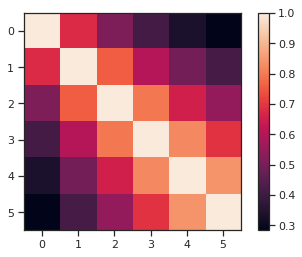

In [4]:
plt.imshow(np.mean(corr_mat,axis=2))
plt.colorbar()

# Calculate activity flow accuracy across all component sizes

In [5]:
# activity
activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=[task])
n_roi = activity['scap']['CTRL'].shape[0]

Task| scap Data loaded: 100.0 %


In [7]:
# generate activity flow predictions seperately in each group holding out certain roi
roi_list = [56, 181, 284, 346] 
df_results = pd.DataFrame()

for comp in range(6):
    print(comp)
    predicted_activity = {}
    predicted_activity[task] = {}
    actFlowWeights = {}
    actFlowWeights[task] = {}

    for group in ['CTRL','SCHZ']:
        print('Running act flow in',group)

        # use non circular fc
        if group == 'CTRL':
            fc_data = fc[:,:,comp,0:93]
        elif group =='SCHZ':
            fc_data = fc[:,:,comp,93:129]

        actPredVector = np.zeros((np.shape(activity[task][group])))
        n_nodes =  np.shape(actPredVector)[0]
        n_conditions = np.shape(actPredVector)[1]
        n_subs = np.shape(actPredVector)[2]
        act_weights_mat = np.zeros((n_nodes,n_nodes,n_conditions,n_subs))

        for condition in range(n_conditions):
            act_data = activity[task][group][:,condition,:].copy()

            for subj in range(np.shape(fc_data)[2]):
                actPredVector[:,condition,subj],act_weights_mat[:,:,condition,subj] = mf.actflowcalc_hold_out_roi(act_data[:,subj],fc_data[:,:,subj],held_out_roi=roi_list)

        predicted_activity[task][group] = actPredVector
        actFlowWeights[task][group] = act_weights_mat
   
    # do stats on the activity flow predictions
    r = {}
    MAE = {}
    MAPE = {}
    Rsqr = {}
    for group in ['CTRL','SCHZ']:
        # do the same contrast
        real = np.mean(activity['scap'][group][:,6:12,:],axis=1) - np.mean(activity['scap'][group][:,0:6,:],axis=1)
        pred = np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1)

        # do actflow statistics
        r[group] = []
        MAE[group] = []
        MAPE[group] = []
        Rsqr[group] = []
        r[group],rs,MAE[group],MAPE[group],Rsqr[group] = mf.actflow_tests(real,pred,normalise=False)
        
        # save the results into big df
        _df = pd.DataFrame()
        _df['Components'] = [component_list[comp]]
        _df['r-Avg'] = np.mean(r[group])
        _df['Group'] = [group]
        _df['MAE-Avg'] = np.mean(MAE[group])

        df_results = pd.concat([df_results,_df])
    
#     # between groups t-test, FDR corrected - replication of the original analysis
#     x = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
#     y = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)

#     for roi in roi_list:
#         display(pg.ttest(x[roi,:],y[roi,:]))

0
Running act flow in CTRL
Running act flow in SCHZ
Mean r across subjs: 0.604 |1samp t: 52.82 p: 0.0
Mean MAE  across subjs: 0.638
Mean MAPE  across subjs: 386.403
Mean R^2  across subjs: 0.371 |1samp t: 25.51 p: 0.0
Mean r across subjs: 0.571 |1samp t: 25.44 p: 0.0
Mean MAE  across subjs: 0.619
Mean MAPE  across subjs: 449.522
Mean R^2  across subjs: 0.333 |1samp t: 12.04 p: 0.0
1
Running act flow in CTRL
Running act flow in SCHZ
Mean r across subjs: 0.63 |1samp t: 56.79 p: 0.0
Mean MAE  across subjs: 0.62
Mean MAPE  across subjs: 371.684
Mean R^2  across subjs: 0.393 |1samp t: 25.98 p: 0.0
Mean r across subjs: 0.598 |1samp t: 30.36 p: 0.0
Mean MAE  across subjs: 0.607
Mean MAPE  across subjs: 491.905
Mean R^2  across subjs: 0.35 |1samp t: 13.03 p: 0.0
2
Running act flow in CTRL
Running act flow in SCHZ
Mean r across subjs: 0.638 |1samp t: 57.17 p: 0.0
Mean MAE  across subjs: 0.617
Mean MAPE  across subjs: 386.577
Mean R^2  across subjs: 0.389 |1samp t: 23.53 p: 0.0
Mean r across sub

# Plot

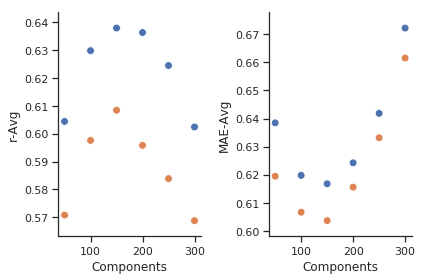

In [37]:
plt.subplot(1,2,1)
g = sns.scatterplot(x='Components',y='r-Avg',hue='Group',data=df_results,s=60)
g.get_legend().set_visible(False)
sns.despine()

plt.subplot(1,2,2)
g = sns.scatterplot(x='Components',y='MAE-Avg',hue='Group',data=df_results,s=60)
g.get_legend().set_visible(False)
sns.despine()
plt.tight_layout()

plt.savefig(figure_dir + 'PCA_comparisons.svg',dpi=600)
plt.savefig(figure_dir + 'PCA_comparisons.jpeg',dpi=600)
plt.show()